# Notebook to generate figure 1 and 4
experimental parameters:
- dataset : September 24, 2020 with and without potassium
- exposure time: 75 ms
- time between images : 12 ms
- number of images in each reference wing: 100

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from uncertainties import ufloat, unumpy
import scipy.stats
import os
import math
from numpy import random
from scipy.stats import poisson

## Digitize Sodium data 

In [2]:
#Github_folder =R"C:\Users\Rohit Prasad Bhatt"
#Github_folder =R"C:\Users\Jan"
Github_folder =R"C:\Users\Lilo"
#Github_folder= "/Users/fredjendrzejewski"
PATH_raw_wK = os.path.join(Github_folder, "Documents/GitHub/StocDyn_fig_data/data/raw/Sep24_Scan_0001_use_K=True.csv")
PATH_raw_woK = os.path.join(Github_folder, "Documents/GitHub/StocDyn_fig_data/data/raw/Sep24_Scan_0001_use_K=False.csv")
PATH_fig = os.path.join(Github_folder, "Documents/GitHub/StocDyn_fig_data/figures/figure1_4")

#### Reshaping the raw data properly

In [3]:
def analyze(file_path, Cam_EXPOT):
    Counts=pd.read_csv(file_path,  encoding='UTF-8')
    Split_Counts=np.array_split(Counts['Counts'],len(Counts['Run_number'].unique()))
    Split_Counts_array=np.array(Split_Counts)
    Nruns, Nimg = Split_Counts_array.shape
    atom_images = np.size(Split_Counts_array[1])
    time_between_atom_images = 12e-3
    time = np.arange(atom_images)*(time_between_atom_images + Cam_EXPOT)
    return time, Nruns, Nimg, Split_Counts_array;

In [4]:
time_raw_wK, Nruns_wK, Nimg_wK, Split_Counts_array_raw_wK = analyze(PATH_raw_wK, Cam_EXPOT=75e-3)
time_raw_woK, Nruns_woK, Nimg_woK, Split_Counts_array_raw_woK = analyze(PATH_raw_woK, Cam_EXPOT=75e-3)

#### Plotting the histogram to extract calibration factor
we plot all the data in a histogram, to extract the calibration factor (the distance between consecutive peaks) which is needed for the digitization of the data

In [5]:
allcounts_offsetremoved_wK=(Split_Counts_array_raw_wK[:,100:300])+0 # make quick deepcopy
offset_wK=np.mean(Split_Counts_array_raw_wK[:,2:89], axis=1) # calculate offset from first reference wing
allcounts_offsetremoved_wK=allcounts_offsetremoved_wK-offset_wK[:,None]
allcounts_offsetremoved_wK=allcounts_offsetremoved_wK.flatten()

allcounts_offsetremoved_woK=(Split_Counts_array_raw_woK[:,100:300])+0 # make quick deepcopy
offset_woK=np.mean(Split_Counts_array_raw_woK[:,2:89], axis=1) # calculate offset from first reference wing
allcounts_offsetremoved_woK=allcounts_offsetremoved_woK-offset_woK[:,None]
allcounts_offsetremoved_woK=allcounts_offsetremoved_woK.flatten()

allcounts_offsetremoved=np.append(allcounts_offsetremoved_woK,allcounts_offsetremoved_wK)

In [6]:
bins=np.linspace(-1e4,2e4, 200)
y, bins = np.histogram(allcounts_offsetremoved, bins=bins)
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])

In [7]:
def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/(2*sigma**2))

In [8]:
def Multimodal(x,mu1,sigma1,A1,mu2,sigma2,A2,mu3,sigma3,A3):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)

In [9]:
expected=(0,1e3,5000,3e3,3e3,5000,6e3,4e3,1500)
params,cov=curve_fit(Multimodal,binscenters,y,expected,absolute_sigma=True)#, bounds=([-1e3,0.1e3,150,6e3,0.1e3,5,2e4,0.1e3,5], [1e3,3e3,22000,12e3,3e3,5000,3e4,3e3,7000]))
sigma=np.sqrt(np.diag(cov))

In [10]:
calibration=params[::3]
step_sizes=np.diff(calibration)
calibration_error=params[1::3]
mu_step = np.mean(step_sizes)
print('Mean dist between consecutive peaks {:.2f}'.format(mu_step))

Mean dist between consecutive peaks 3099.93


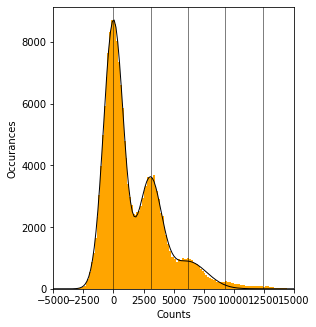

In [11]:
fig2 = plt.figure(figsize=(4.5,5)) 
ax2 = fig2.add_subplot(1, 1, 1)
ax2.plot((bins-params[0]),Multimodal(bins,*params),color='black',lw=1,label='model');
ax2.hist((allcounts_offsetremoved-params[0]),color='orange', bins=bins, label='data')
for ii in range(6):
    ax2.axvline(ii*mu_step, color='black', ls='-', lw=0.5)
#ax2.legend()
ax2.set_xlim(-5000,15000)
ax2.set_xlabel("Counts")
ax2.set_ylabel("Occurances")
fig2.tight_layout()
fig2.subplots_adjust(top=0.9);

### Information for generating digitized data
We use __generate_digitized_CSV.ipynb__ for generating the digitized data. The neccesary information is given below.

### Loading the digitized sodium data

In [ ]:
PATH_woK = os.path.join(Github_folder, "Documents/GitHub/sopa_rsi/analysis_data/Analyse_Jump_Statistics/Scan_0001_of_20-09-24_use_K=False_digitized_on_2020-12-20.csv")
PATH_wK = os.path.join(Github_folder, "Documents/GitHub/sopa_rsi/analysis_data/Analyse_Jump_Statistics/Scan_0001_of_20-09-24_use_K=True_digitized_on_2020-12-20.csv")

## Load Potassium data and select only runs where we have sodium and potassium data analysed


In [ ]:
PATH_K = os.path.join(Github_folder, "Documents/GitHub/sopa_rsi/analysis_data/Time_Traces_Na_in_K/Sept24_K_Scan_0001_use_K=True.csv")

In [ ]:
Counts_w_K=pd.read_csv(PATH_raw_wK,  encoding='UTF-8')
Counts_w_K_dig=pd.read_csv(PATH_wK,  encoding='UTF-8')
Counts_K=pd.read_csv(PATH_K,  encoding='UTF-8')

req_runs=Counts_K.Run_number.unique()

subset_Counts_w_K=Counts_w_K.loc[Counts_w_K['Run_number'].isin(req_runs)]
subset_Counts_w_K_dig=Counts_w_K_dig.loc[Counts_w_K_dig['Run_number'].isin(req_runs)]

Split and delete two "wrong" data point

In [ ]:
Split_subset_Counts_w_K=np.array_split(subset_Counts_w_K['Counts'],len(subset_Counts_w_K['Run_number'].unique()))
Split_subset_Counts_w_K_dig=np.array_split(subset_Counts_w_K_dig['Counts'],len(subset_Counts_w_K_dig['Run_number'].unique()))
Split_Counts_K=np.array_split(Counts_K['Counts'],len(Counts_K['Run_number'].unique()))

Split_subset_Counts_w_K=np.array(Split_subset_Counts_w_K)
Split_subset_Counts_w_K_dig=np.array(Split_subset_Counts_w_K_dig)
Split_Counts_K=np.array(Split_Counts_K)

Split_subset_Counts_w_K=np.delete(Split_subset_Counts_w_K, 100,1)
Split_subset_Counts_w_K_dig=np.delete(Split_subset_Counts_w_K_dig, 100,1)
Split_Counts_K=np.delete(Split_Counts_K, 100,1)
Split_subset_Counts_w_K=np.delete(Split_subset_Counts_w_K, 0,1)
Split_subset_Counts_w_K_dig=np.delete(Split_subset_Counts_w_K_dig, 0,1)
Split_Counts_K=np.delete(Split_Counts_K, 0,1)

In [ ]:
atom_images_K = np.size(Split_subset_Counts_w_K[19])
time_between_atom_images = 12e-3
Cam_EXPOT_K = 75e-3
time = np.arange(atom_images_K)*(time_between_atom_images + Cam_EXPOT_K)

### Calibration factor for potassium
We extract calibration factor for converting camera counts into atom numbers for potassium from script Fig5:

In [ ]:
C_K_100 = 5.61e2  # calibration factor for 100ms integration time
C_K_75  = C_K_100*0.75 # Here we are using 75ms integration time

## Ploting the figures

In [ ]:
n = 19 # We are choosing the 19th run 
y1 = Split_subset_Counts_w_K[n]
y_dig = Split_subset_Counts_w_K_dig[n]
y2 = Split_Counts_K[n]

In [ ]:
fig = plt.figure(figsize=(7,5)) 
ax1 = fig.add_subplot(1, 1, 1)
ax=ax1.twinx()
ax1.plot(y_dig, '-', color= 'orange', alpha=1, zorder=10, linewidth=4)
ax.plot((y2)/C_K_75, '.-', color='royalblue', alpha=1, zorder=1)
ax.set_xlabel("Image index")
ax1.set_ylabel("Na Atom number")
ax.set_ylabel("K Atom number")
ax1.set_xlabel("Image index")
ax.set_xlim(0,400)
ax1.set_ylim(-0.5,3)
ax.set_ylim(-3.6e3,21e3)
fig.tight_layout()
fig.subplots_adjust(top=0.9);
my_file = 'NaK_Time_Trace_V2.pdf'
fig.savefig(os.path.join(PATH_fig, my_file)) 

In [ ]:
fig = plt.figure(figsize=(7,5)) 
ax1 = fig.add_subplot(1, 1, 1)
ax=ax1.twinx()
ax.plot((y2), '.-', color='royalblue')#royalblue
ax1.plot((y1-np.mean(y1[0:49])), '.-', color= 'orange', alpha=0.4)
ax1.plot(y_dig*mu_step, '-', color= 'orange', markersize=3, alpha=1.0, lw=3)
ax1.set_xlabel("Image index")
ax.set_ylabel("Camera counts K")
ax1.set_ylabel("Camera counts Na")
ax.set_xlim(0,400)
ax1.set_ylim(-2.2e3,1.0e4)
ax.set_ylim(-2e6,0.9e7)
fig.tight_layout()
fig.subplots_adjust(top=0.9);
my_file = 'NaK_Time_Trace_V4.pdf'
fig.savefig(os.path.join(PATH_fig, my_file)) 